In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, 
                                     MaxPooling2D, Concatenate, Flatten, Dense, Add, 
                                     AveragePooling2D, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import (confusion_matrix, roc_curve, auc, 
                             precision_score, recall_score, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import copy
from collections import deque
import math
import time

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

2025-12-10 17:37:39.243124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765388259.482627      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765388259.547345      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1.1 Global Configuration

In [2]:
DEFAULT_HYPERPARAMS = {
    "input_shape": (224, 224, 3),
    "num_classes": 3,
    "learning_rate": 0.0001,
    "epochs": 50,
    "batch_size": 16
}

BASE_PATH = "/kaggle/input/feature-selelcted-dataset"
CATEGORIES = ['normal', 'covid19', 'pneumonia']
IMAGE_SIZE = (DEFAULT_HYPERPARAMS['input_shape'][0], DEFAULT_HYPERPARAMS['input_shape'][1])
LABEL_MAPPING = {'covid19': 0, 'pneumonia': 1, 'normal': 2}
TARGET_NAMES = ['Covid-19', 'Pneumonia', 'Normal']

optimization_summary = {}

# 1. Data Loading and Preprocessing

In [3]:
def load_images(folder, categories, image_size):
    
    images, labels = [], []
    for category in categories:
        category_path = os.path.join(folder, category)
        if not os.path.isdir(category_path):
            print(f"Warning: Directory not found: {category_path}")
            continue
            
        for filename in os.listdir(category_path):
            img_path = os.path.join(category_path, filename)
            try:
                img = cv2.imread(img_path)  # Load in BGR
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
                    img = cv2.resize(img, image_size)
                    images.append(img)
                    labels.append(category)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                
    return np.array(images).astype('float32'), np.array(labels)

In [4]:
def encode_labels(labels, label_mapping, num_classes):
    int_labels = [label_mapping[label] for label in labels]
    return tf.keras.utils.to_categorical(int_labels, num_classes=num_classes).astype('float32')

train_images, train_labels_raw = load_images(
    os.path.join(BASE_PATH, 'train'), CATEGORIES, IMAGE_SIZE
)
test_images_full, test_labels_full_raw = load_images(
    os.path.join(BASE_PATH, 'test'), CATEGORIES, IMAGE_SIZE
)

val_images, test_images, val_labels_raw, test_labels_raw = train_test_split(
    test_images_full, test_labels_full_raw, 
    test_size=0.75, 
    stratify=test_labels_full_raw, 
    random_state=42
)

train_labels = encode_labels(train_labels_raw, LABEL_MAPPING, DEFAULT_HYPERPARAMS['num_classes'])
val_labels = encode_labels(val_labels_raw, LABEL_MAPPING, DEFAULT_HYPERPARAMS['num_classes'])
test_labels = encode_labels(test_labels_raw, LABEL_MAPPING, DEFAULT_HYPERPARAMS['num_classes'])

print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Test images shape: {test_images.shape}")

Train images shape: (1205, 224, 224, 3)
Validation images shape: (75, 224, 224, 3)
Test images shape: (227, 224, 224, 3)


# 2. Data Augmentation & Generators

## 2.1 Create Data Generators

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(
    x=train_images,
    y=train_labels,
    batch_size=DEFAULT_HYPERPARAMS['batch_size'],
    shuffle=True
)

validation_generator = val_test_datagen.flow(
    x=val_images,
    y=val_labels,
    batch_size=DEFAULT_HYPERPARAMS['batch_size'],
    shuffle=True
)

test_generator = val_test_datagen.flow(
    x=test_images,
    y=test_labels,
    batch_size=DEFAULT_HYPERPARAMS['batch_size'],
    shuffle=False
)

In [6]:
steps_per_epoch = math.ceil(len(train_images) / DEFAULT_HYPERPARAMS['batch_size'])
validation_steps = math.ceil(len(val_images) / DEFAULT_HYPERPARAMS['batch_size'])
test_steps = math.ceil(len(test_images) / DEFAULT_HYPERPARAMS['batch_size'])

# 3. Core Helper Functions (Model & Evaluation)

In [7]:
def build_vgg16_model(input_shape, num_classes, dropout_rate, learning_rate, dense_units):
    """
    Creates the VGG16 model with a custom hyperparameterized classification head.
    This function is used by all optimization algorithms.
    """
    inputs = tf.keras.Input(shape=input_shape, name='input_1')
    weights = 'imagenet'
    weights_path = os.path.expanduser('~/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    if os.path.exists(weights_path):
        weights = weights_path

    base_model = VGG16(weights=weights, include_top=False, input_tensor=inputs)
    base_model.trainable = False

    layer_name_mapping = {
        'block1_conv1': 'Glock1_conv1', 'block1_conv2': 'Glock1_conv2', 'block1_pool': 'Glock1_pool',
        'block2_conv1': 'Glock2_conv1', 'block2_conv2': 'Glock2_conv2', 'block2_pool': 'Glock2_coel',
        'block3_conv1': 'Glock3_conv1', 'block3_conv2': 'Glock3_conv2', 'block3_conv3': 'Glock3_conv3', 'block3_pool': 'Glock3_coel',
        'block4_conv1': 'Glock4_conv1', 'block4_conv2': 'Glock4_conv2', 'block4_conv3': 'Glock4_conv3', 'block4_pool': 'Glock4_coel',
        'block5_conv1': 'Glock5_conv1', 'block5_conv2': 'Glock5_conv2', 'block5_conv3': 'Glock5_conv3', 'block5_pool': 'Glock5_coel'
    }
    for layer in base_model.layers:
        if layer.name in layer_name_mapping:
            layer._name = layer_name_mapping[layer.name]
    
    x = base_model.output
    x = AveragePooling2D(pool_size=(4, 4), name='Avarage_poolZhg8')(x)
    x = Flatten(name='Atsitas')(x)
    
    x = Dense(dense_units, activation='relu', name='Aonte')(x)
    
    x = Dropout(dropout_rate, name='Argoat_dropout')(x)
    outputs = Dense(num_classes, activation='softmax', name='Gonsu_2_softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='nCOVnet_Optimized')

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
def plot_training_history(history, title="Model Training History"):
    """
    Plots accuracy and loss curves for a given Keras history object.
    Returns the max validation accuracy and min validation loss.
    """
    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    max_val_acc = max(history.history['val_accuracy'])
    min_val_loss = min(history.history['val_loss'])
    return max_val_acc, min_val_loss

In [9]:
def evaluate_model(model, test_generator, target_names, title="Model Evaluation"):

    print(f"\n--- {title} ---")
    
    # 0. Evaluate model for loss and accuracy
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # 1. Make predictions
    y_pred_probs = model.predict(test_generator, steps=test_steps)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # 2. Get true labels
    # We use test_generator.y which we know is not shuffled
    y_true = np.argmax(test_generator.y, axis=1)
    
    # 3. Print Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))

    # 4. Calculate Sensitivity and Specificity
    cm = confusion_matrix(y_true, y_pred)
    sensitivities, specificities = [], []
    for i in range(len(cm)):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    overall_sensitivity = np.mean(sensitivities)
    overall_specificity = np.mean(specificities)
    
    print(f"Overall Sensitivity (macro-averaged) = {overall_sensitivity:.4f}")
    print(f"Overall Specificity (macro-averaged) = {overall_specificity:.4f}")

    # 5. Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # 6. Plot ROC Curve (One vs Rest)
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = len(target_names)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_generator.y[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve ({target_names[i]}) (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {title}')
    plt.legend(loc='lower right')
    plt.show()
    
    return test_loss, test_accuracy, overall_sensitivity, overall_specificity

# 4. Optimization

## 4.1. Bounds Definition

In [36]:
BOUNDS = [
    (1e-5, 1e-3, "log"),     # learning rate
    (8, 32, "int"),          # batch size
    (0.0, 0.6, "linear"),    # dropout
    (2, 6, "int"),           # epochs (kept small)
    (16, 256, "int")         # dense units
]

## 4.2. Particle Definition

In [37]:
class Particle:
    def __init__(self, bounds):
        self.position = []
        self.velocity = []

        for lo, hi, t in bounds:
            if t == "log":
                val = 10 ** np.random.uniform(np.log10(lo), np.log10(hi))
            elif t == "int":
                val = np.random.randint(lo, hi + 1)
            else:
                val = np.random.uniform(lo, hi)

            self.position.append(val)
            self.velocity.append(0.0)

        self.best_position = self.position.copy()
        self.best_score = -np.inf

## 4.3. Utility Functions

In [38]:
def clip_value(index, value):
    lo, hi, t = BOUNDS[index]
    if t == "int":
        value = int(round(value))
    return max(lo, min(hi, value))


def decode_particle(p):
    return {
        "lr": float(p.position[0]),
        "batch": int(p.position[1]),
        "dropout": float(p.position[2]),
        "epochs": int(p.position[3]),
        "dense": int(p.position[4])
    }

# 4.4. Particle Evaluation

In [39]:
def evaluate_particle(p, X_train, y_train, X_val, y_val, pid):
    params = decode_particle(p)

    print(f"      Particle {pid} evaluation:")
    for k, v in params.items():
        print(f"        {k}: {v}")

    model = build_vgg16_model(
        X_train.shape[1:],
        y_train.shape[1],
        params["dropout"],
        params["lr"],
        params["dense"]
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=params["batch"],
        epochs=params["epochs"],
        verbose=0
    )

    score = max(history.history["val_accuracy"])
    print(f"        Validation accuracy: {score:.4f}")

    del model
    tf.keras.backend.clear_session()

    return score

## 4.5. PSO Execution

In [40]:
def run_pso(w, c1, c2, X_train, y_train, X_val, y_val):
    print("\nStarting PSO")
    print(f"  Inertia (w): {w}")
    print(f"  Cognitive (c1): {c1}")
    print(f"  Social (c2): {c2}")

    NUM_PARTICLES = 5
    NUM_ITER = 4

    swarm = [Particle(BOUNDS) for _ in range(NUM_PARTICLES)]
    global_best_score = -np.inf
    global_best_position = None

    for it in range(NUM_ITER):
        print(f"\n  PSO Iteration {it + 1}/{NUM_ITER}")

        for i, p in enumerate(swarm):
            score = evaluate_particle(
                p, X_train, y_train, X_val, y_val, i
            )

            if score > p.best_score:
                p.best_score = score
                p.best_position = p.position.copy()
                print(f"        Particle {i} updated personal best")

            if score > global_best_score:
                global_best_score = score
                global_best_position = p.position.copy()
                print(f"        Global best updated by particle {i}")

        print("    Updating particle velocities and positions")

        for i, p in enumerate(swarm):
            for d in range(len(p.position)):
                r1, r2 = np.random.rand(), np.random.rand()

                cognitive = c1 * r1 * (p.best_position[d] - p.position[d])
                social = c2 * r2 * (global_best_position[d] - p.position[d])

                p.velocity[d] = (
                    w * p.velocity[d] + cognitive + social
                )

                p.position[d] = clip_value(
                    d, p.position[d] + p.velocity[d]
                )

    print(f"\nPSO finished. Best validation accuracy: {global_best_score:.4f}")
    return global_best_score

## 4.6. Hill Climbing over PSO Parameter

In [41]:
PSO_SPACE = {
    "w":  np.arange(0.2, 0.9 + 0.1, 0.1),
    "c1": np.arange(0.5, 2.5 + 0.25, 0.25),
    "c2": np.arange(0.5, 2.5 + 0.25, 0.25)
}

In [42]:
def random_pso_config():
    return {
        "w": float(random.choice(PSO_SPACE["w"])),
        "c1": float(random.choice(PSO_SPACE["c1"])),
        "c2": float(random.choice(PSO_SPACE["c2"]))
    }

In [43]:
def evaluate_pso_config(cfg, X_train, y_train, X_val, y_val):
    print("\nEvaluating PSO configuration:")
    for k, v in cfg.items():
        print(f"  {k}: {v}")

    tf.keras.backend.clear_session()

    score = run_pso(
        cfg["w"], cfg["c1"], cfg["c2"],
        X_train, y_train, X_val, y_val
    )

    print(f"Configuration score: {score:.4f}")
    return score

In [44]:
def hill_climb_pso(start_cfg, X_train, y_train, X_val, y_val, restarts=5):
    print("\nStarting Hill Climbing on PSO parameters")
    print("Initial configuration:", start_cfg)

    best_cfg = start_cfg.copy()
    best_score = evaluate_pso_config(best_cfg, X_train, y_train, X_val, y_val)

    for r in range(restarts):
        print(f"\nHill Climbing restart {r + 1}/{restarts}")

        candidate_cfg = random_pso_config()
        score = evaluate_pso_config(
            candidate_cfg, X_train, y_train, X_val, y_val
        )

        if score > best_score:
            print("New best PSO configuration found")
            best_score = score
            best_cfg = candidate_cfg.copy()
        else:
            print("No improvement")

    print("\nHill Climbing finished")
    print("Best PSO configuration:", best_cfg)
    print(f"Best validation accuracy: {best_score:.4f}")

    return best_cfg, best_score

## 4.7. Main Execution

In [45]:
start_time = time.time()

INITIAL_PSO_CONFIG = {
    "w": 0.5,
    "c1": 1.0,
    "c2": 1.0
}

best_params, best_score = hill_climb_pso(
    INITIAL_PSO_CONFIG,
    train_images, train_labels,
    val_images, val_labels,
    restarts=5
)

elapsed_time = time.time() - start_time

print("\nFinal results")
print("Best PSO parameters:", best_params)
print(f"Best validation accuracy: {best_score:.4f}")
print(f"Total runtime: {elapsed_time:.2f} seconds")


Starting Hill Climbing on PSO parameters
Initial configuration: {'w': 0.5, 'c1': 1.0, 'c2': 1.0}

Evaluating PSO configuration:
  w: 0.5
  c1: 1.0
  c2: 1.0

Starting PSO
  Inertia (w): 0.5
  Cognitive (c1): 1.0
  Social (c2): 1.0

  PSO Iteration 1/4
      Particle 0 evaluation:
        lr: 3.0342470058112858e-05
        batch: 14
        dropout: 0.36599799466957256
        epochs: 4
        dense: 221
        Validation accuracy: 0.6267
        Particle 0 updated personal best
        Global best updated by particle 0
      Particle 1 evaluation:
        lr: 6.055098539300353e-05
        batch: 25
        dropout: 0.39751337061238917
        epochs: 3
        dense: 149
        Validation accuracy: 0.6533
        Particle 1 updated personal best
        Global best updated by particle 1
      Particle 2 evaluation:
        lr: 2.6054534945803988e-05
        batch: 11
        dropout: 0.11091267331531622
        epochs: 3
        dense: 233
        Validation accuracy: 0.6400
      

In [50]:
BEST_HYPERPARAMS = {
    "learning_rate": 0.001,
    "batch_size": 19,
    "dropout": 0.5185103644947976,
    "epochs": 50,
    "dense_units": 256
}

print("\n=== Training Final Model with Best Hyperparameters ===")
print(BEST_HYPERPARAMS)


=== Training Final Model with Best Hyperparameters ===
{'learning_rate': 0.001, 'batch_size': 19, 'dropout': 0.5185103644947976, 'epochs': 50, 'dense_units': 256}


In [51]:
final_model = build_vgg16_model(
    input_shape=train_images.shape[1:],         # (224,224,3)
    num_classes=train_labels.shape[1],          # 3 classes
    dropout_rate=BEST_HYPERPARAMS["dropout"],
    learning_rate=BEST_HYPERPARAMS["learning_rate"],
    dense_units=BEST_HYPERPARAMS["dense_units"]
)

final_model.summary()

Model: "nCOVnet_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Avarage_poolZhg8                │ (None, 1, 1, 512)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Atsitas (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Aonte (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Argoat_dropout (Dropout)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Gonsu_2_softmax (Dense)         │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,846,787 (56.64 MB)

 Trainable params: 132,099 (516.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [52]:
final_train_gen = train_datagen.flow(
    train_images, train_labels,
    batch_size=BEST_HYPERPARAMS["batch_size"],
    shuffle=True
)

final_val_gen = val_test_datagen.flow(
    val_images, val_labels,
    batch_size=BEST_HYPERPARAMS["batch_size"],
    shuffle=False
)

In [53]:
history = final_model.fit(
    final_train_gen,
    validation_data=final_val_gen,
    epochs=BEST_HYPERPARAMS["epochs"],
    verbose=1
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.4842 - loss: 1.0308 - val_accuracy: 0.6667 - val_loss: 0.6905
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.6441 - loss: 0.6932 - val_accuracy: 0.6800 - val_loss: 0.6173
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.7079 - loss: 0.6037 - val_accuracy: 0.6533 - val_loss: 0.6118
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 0.6970 - loss: 0.6044 - val_accuracy: 0.6800 - val_loss: 0.5869
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.6853 - loss: 0.5814 - val_accuracy: 0.6267 - val_loss: 0.5736
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.7087 - loss: 0.5570 - val_accuracy: 0.6400 - val_loss: 0.5733
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.7030 - loss: 0.5766 - val_accuracy: 0.6667 - val_loss: 0.5809
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.7301 - loss: 0.5419 - val_accu

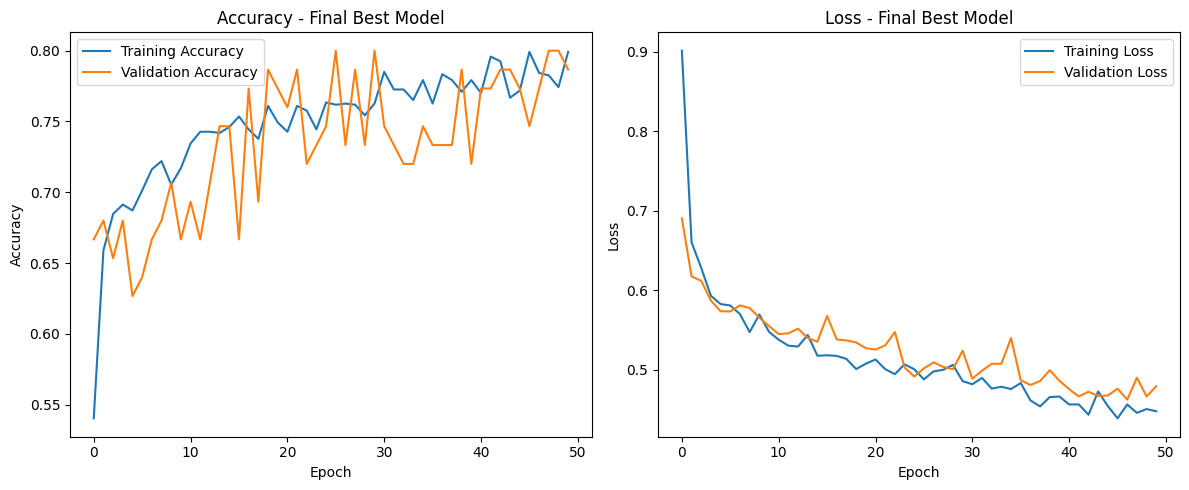

(0.800000011920929, 0.46237456798553467)

In [54]:
plot_training_history(history, title="Final Best Model")


--- Final Model Evaluation ---
Test Loss: 0.4322, Test Accuracy: 0.8326
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step

Classification Report:
              precision    recall  f1-score   support

    Covid-19       0.81      0.74      0.77        76
   Pneumonia       0.72      0.87      0.79        75
      Normal       1.00      0.89      0.94        76

    accuracy                           0.83       227
   macro avg       0.84      0.83      0.83       227
weighted avg       0.85      0.83      0.84       227

Overall Sensitivity (macro-averaged) = 0.8327
Overall Specificity (macro-averaged) = 0.9165


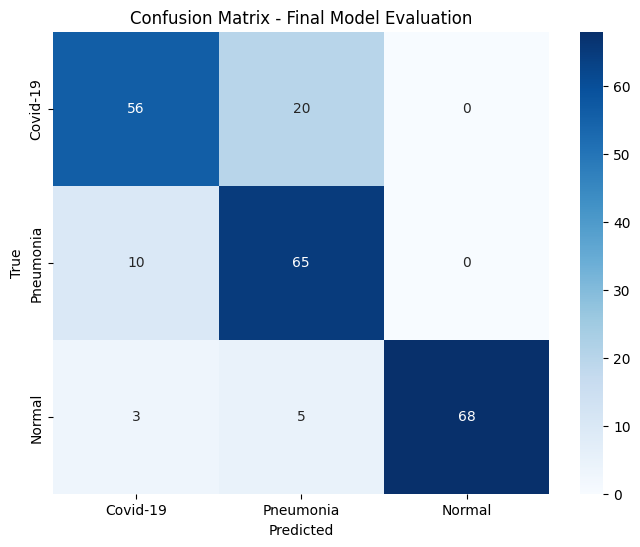

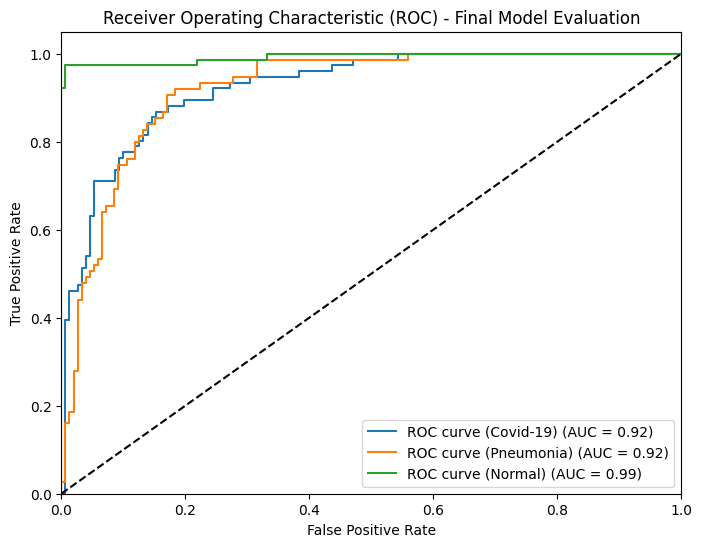

(0.43223369121551514,
 0.8325991034507751,
 0.832748538011696,
 0.9164778668525618)

In [55]:
evaluate_model(
    final_model,
    test_generator,
    TARGET_NAMES,
    title="Final Model Evaluation"
)